#### Specify Jupyter extensions

`matplotlib inline` allows visualizing the plots in the notebook. `autoreload` allows external modules to be reloaded automatically to keep track of any changes made therein.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Import the Python libraries and custom modules as needed

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

# Import scikit-learn for functions and datasets.
import sklearn
from sklearn.datasets import load_digits
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.datasets import fetch_openml

# Import OpenCV to save the weights as frames of a video.
import cv2

# Import the custom module for helper functions
from utils import *

In [3]:
# Specifying seed value for reproducibility.

seedval = 8888
np.random.seed(seedval)

In [4]:
# Specifying project directories.

savedir = 'SavedFigs/'

# Question 1

## Loading, validating, and exploring the dataset

In [5]:
digits_dset = load_digits()

print("Shape of input data:", digits_dset.data.shape)
print("Shape of target labels:", digits_dset.target.shape)
print("Target labels:", digits_dset.target_names)

Shape of input data: (1797, 64)
Shape of target labels: (1797,)
Target labels: [0 1 2 3 4 5 6 7 8 9]


In [6]:
# We want to count the sample population of each target label in the dataset.

print("Class-wise sample counts")

# For every label, count the number of occurrences of it in the dataset.
for label in range(10):
    print(label, '->' , len(np.where(digits_dset.target == label)[0]))

Class-wise sample counts
0 -> 178
1 -> 182
2 -> 177
3 -> 183
4 -> 181
5 -> 182
6 -> 181
7 -> 179
8 -> 174
9 -> 180


## Select the 2 classes based on user inputs  `class0` and `class1`

In [7]:
class0, class1 = 2, 7

## Partition the dataset into training and testing splits

In [8]:
# Specify the percentage of the dataset to be held out for testing
test_frac = 0.4

In [9]:
# Use a custom-designed function that takes the dataset, the 2 classes, 
# the test fraction, and the random seed value as input, and returns
# training and testing inputs and labels.
x_train, x_test, y_train, y_test = prepare_data(X=digits_dset.data, 
                                                Y=digits_dset.target, 
                                                class0=class0, 
                                                class1=class1, 
                                                test_split_fraction=test_frac, 
                                                seedval=seedval)

print('Training partition input data shape:', x_train.shape)
print('Training partition labels shape:', y_train.shape)
print('Testing partition input data shape:', x_test.shape)
print('Testing partition labels shape:', y_test.shape)

# Infer the number of data points in training and testing partitions
# and the number of features from the shape
n_train, n_test, n_feats = x_train.shape[0], x_test.shape[0], x_train.shape[1]

Training partition input data shape: (213, 64)
Training partition labels shape: (213,)
Testing partition input data shape: (143, 64)
Testing partition labels shape: (143,)


## Train a logistic regression classifier (neuron) using mini-batch stochastic gradient descent and hyperparameter optimization

### Identifying the hyperparameters

The logistic regression classifier has been defined in `utils.py` as a custom class named `LogisticRegressionClassifier`. The hyperparameters associated with it are:
* `lr`: The learning rate of the gradient descent optimization.
* `reg_param`: The regularization parameter (denoted by $\lambda$ in the regularized gradient descent cost equation) for L2 regularization of the classifier's weights.
* `batch_size`: The number of samples in each 'mini-batch' used to update the classifier's parameters in each iteration.
* `n_epochs`: The number of epochs for which the gradient descent optimization is performed.

### Defining the set of values over which hyperparameter optimization is to be performed

In [10]:
# We choose 5 learning rates, 4 regularization parameters (which includes 0. 
# indicating no regularization), 2 batch sizes and 2 number of epochs.

# Note that this means that we are scanning over 5 * 4 * 2 * 2 = 80 sets of
# hyperparameter values (Cartesian product).

lr_vals = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
reg_param_vals = [1, 0.1, 0.01, 0.]
batch_size_vals = [50, 100]
n_epochs_vals = [100, 1000]

### Perform a grid search with K-fold cross validation

In [11]:
# Define a classifier with some hyperparameter values. This is necessary to initialize
# the classifier object. However, these are just placeholder values and we will 
# perform a grid search to choose the best set of values.
clsfr = LogisticRegressionClassifier(n_features=n_feats, 
                                     lr=1e-3, 
                                     reg_param=0.1, 
                                     batch_size=50, 
                                     n_epochs=1000)

# We then initialize a dictionary with the set of possible hyperparameter values so
# that we can perform a grid search over them.
# Inspired by https://bit.ly/3xDCKwa
hyperparam_grid = dict(lr=lr_vals, 
                       reg_param=reg_param_vals, 
                       batch_size=batch_size_vals, 
                       n_epochs=n_epochs_vals)

# Next, we define a K-fold cross validation with K = 3 to select the best set of 
# hyperparameter values.
# We set shuffle=True so that the data is shuffled before each 3-fold split.
KFold_cv = KFold(n_splits=3, shuffle=True, random_state=seedval)

# Next, we define the grid search operation which takes as input the classifier,
# the grid of hyperparameter values, the K-fold cross validation operator, 
# and the scoring function.

# We choose the F1-score as the scoring functions as it produces a better 
# representation of performance for both the classes.
# We set n_jobs=-1 to utilize all the CPU cores and reduce computation time.
# We set error_score=0 to substitute 0 in case the error function cannot be
# calculated for a split.
GridSearch_KFold_cv = GridSearchCV(estimator=clsfr, 
                                   param_grid=hyperparam_grid, 
                                   n_jobs=-1, 
                                   cv=KFold_cv, 
                                   scoring='f1', 
                                   error_score=0)

# Finally, we perform the grid search operation. This will take some time
# to complete since we are fitting 240 models 
# (80 sets of hyperparameters * 3-fold cross validation = 240 models)
GridSearch_KFold_cv_result = GridSearch_KFold_cv.fit(x_train, y_train)

In [12]:
# We print the best set of hyperparameter values
print('The best score is {:.4f} using'.format(GridSearch_KFold_cv_result.best_score_))

for key in GridSearch_KFold_cv_result.best_params_.keys():
    print(key, ':', GridSearch_KFold_cv_result.best_params_[key])

The best score is 1.0000 using
n_epochs : 1000
lr : 0.1
batch_size : 50
reg_param : 1


0.9703 (0.0248) with: {'n_epochs': 100, 'lr': 0.1, 'batch_size': 50, 'reg_param': 1}
0.9606 (0.0306) with: {'n_epochs': 100, 'lr': 0.1, 'batch_size': 50, 'reg_param': 0.1}
0.9606 (0.0306) with: {'n_epochs': 100, 'lr': 0.1, 'batch_size': 50, 'reg_param': 0.01}
0.9606 (0.0306) with: {'n_epochs': 100, 'lr': 0.1, 'batch_size': 50, 'reg_param': 0.0}
1.0000 (0.0000) with: {'n_epochs': 1000, 'lr': 0.1, 'batch_size': 50, 'reg_param': 1}
0.9849 (0.0128) with: {'n_epochs': 1000, 'lr': 0.1, 'batch_size': 50, 'reg_param': 0.1}
0.9606 (0.0306) with: {'n_epochs': 1000, 'lr': 0.1, 'batch_size': 50, 'reg_param': 0.01}
0.9606 (0.0306) with: {'n_epochs': 1000, 'lr': 0.1, 'batch_size': 50, 'reg_param': 0.0}
0.9502 (0.0352) with: {'n_epochs': 100, 'lr': 0.01, 'batch_size': 50, 'reg_param': 1}
0.9502 (0.0352) with: {'n_epochs': 100, 'lr': 0.01, 'batch_size': 50, 'reg_param': 0.1}
0.9502 (0.0352) with: {'n_epochs': 100, 'lr': 0.01, 'batch_size': 50, 'reg_param': 0.01}
0.9502 (0.0352) with: {'n_epochs': 100,

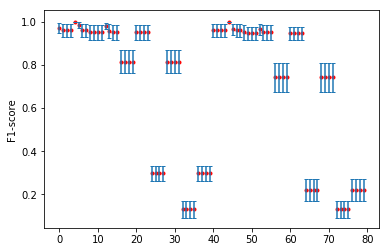

In [13]:
# Next, we print and visualize the performance of all the sets of 
# hyperparameter values.

grid_means = GridSearch_KFold_cv_result.cv_results_['mean_test_score']
grid_stds = GridSearch_KFold_cv_result.cv_results_['std_test_score']
grid_params = GridSearch_KFold_cv_result.cv_results_['params']
for mean, stdev, param in zip(grid_means, grid_stds, grid_params):
    print("%.4f (%.4f) with: %r" % (mean, stdev, param))
    
# For visualizing, we plot each hyperparameter value set's F1-score
# and denote the variation between the 3 folds as error bars.
plt.scatter(np.arange(0, 80, 1), grid_means, color='r', marker='.')
plt.errorbar(np.arange(0, 80, 1), grid_means, grid_stds, linestyle='None', capsize=2)
plt.ylabel('F1-score')
# plt.savefig(savedir + 'Q1_1.png', dpi=300, bbox_inches='tight')
plt.show()

### Training the classifier with the best hyperparameters

In [14]:
# Initialize a classifier with the hyperparameters set to the values
# calculated above.

train_epochs = GridSearch_KFold_cv_result.best_params_['n_epochs']

clsfr = LogisticRegressionClassifier(n_features=n_feats, 
                                     lr=GridSearch_KFold_cv_result.best_params_['lr'], 
                                     reg_param=GridSearch_KFold_cv_result.best_params_['reg_param'], 
                                     batch_size=GridSearch_KFold_cv_result.best_params_['batch_size'], 
                                     n_epochs=1)

# Initialize empty dictionaries to keep track of epoch-wise loss
# values, classifier parameters, and classification accuracies.
losses, params, acc = {}, {}, {}

# Initialize the loss and accuracy dictionaries with zeros for 
# training and testing partitions.
losses['train'], losses['test'] = np.zeros(train_epochs), np.zeros(train_epochs)
acc['train'], acc['test'] = np.zeros(train_epochs), np.zeros(train_epochs)

# Initialize the parameter dictionary with zeros for the classifier's
# weights and biases.
params['W'], params['b'] = np.zeros((train_epochs, n_feats)), np.zeros(train_epochs)

# Fit the classifier one training epoch at a time, so as to keep track 
# of the metrics every epoch.
for epoch in range(train_epochs):
    # Fit the classifier for one epoch.
    clsfr.fit(x_train, y_train)
    # Log the training loss.
    losses['train'] = np.array(clsfr.loss_values_)
    # Log the weights and the bias of the classifier.
    params['W'][epoch], params['b'][epoch] = clsfr.params_['W'], clsfr.params_['b']
    
    # Calculate the model's predictions for the training and the test
    # partitions.
    pred_train = clsfr.predict(x_train, y_train, calculate_loss=False)
    pred_test, losses['test'][epoch] = clsfr.predict(x_test, y_test, calculate_loss=True)
    
    # Calculate the model's accuracy for the training and the test
    # partitions.
    acc['train'][epoch] = (pred_train == y_train).sum() / n_train
    acc['test'][epoch] = (pred_test == y_test).sum() / n_test

### Plotting the classifier's loss and accuracy over the course of training

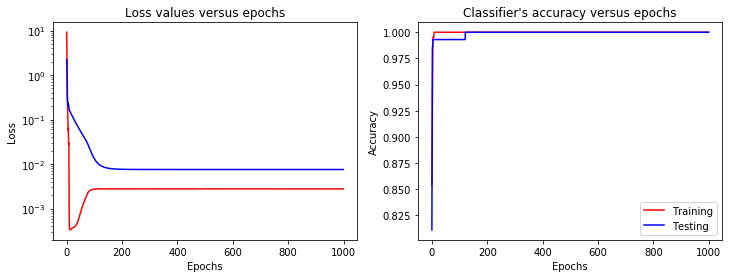

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(losses['train'], 'r', label='Training')
axs[0].plot(losses['test'], 'b', label='Testing')
axs[0].set_yscale('log')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(acc['train'], 'r', label='Training')
axs[1].plot(acc['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
# plt.savefig(savedir + 'Q1_2.png', dpi=300, bbox_inches='tight')
plt.show()

### Visualizing the classifier's parameters (weights and bias)

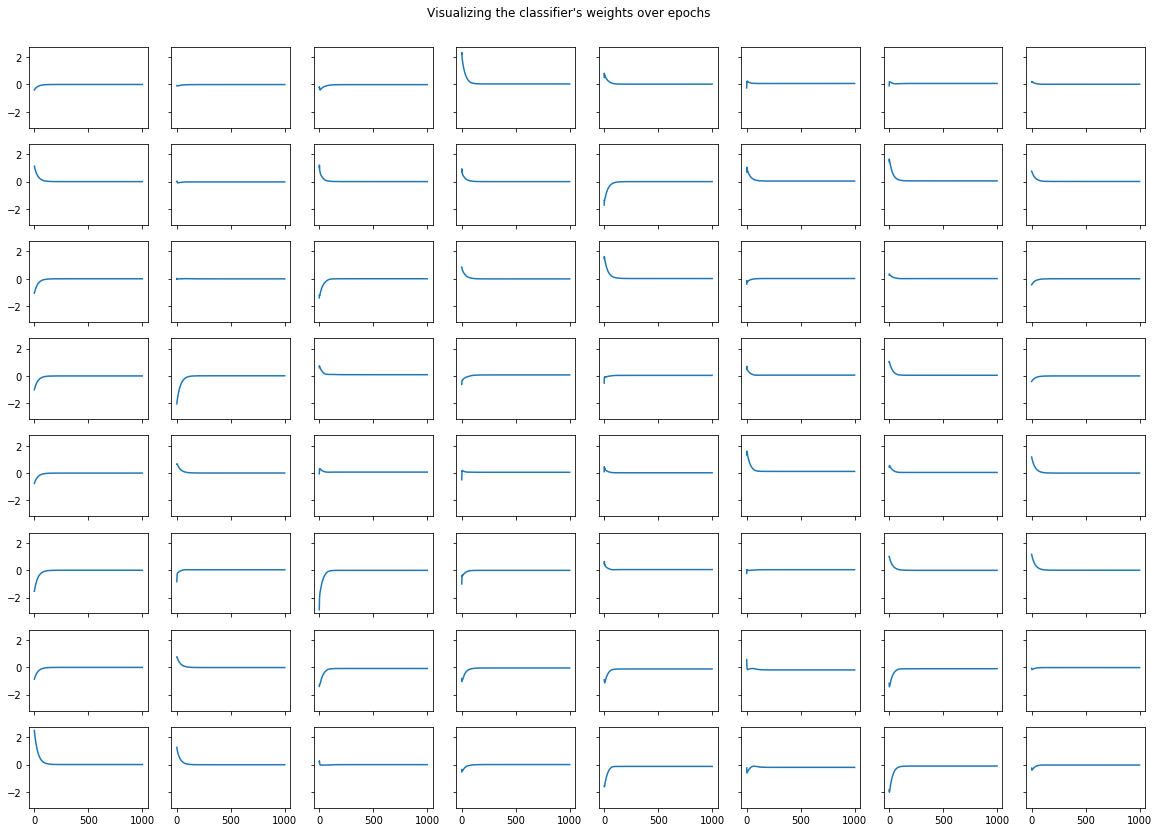

In [16]:
# First, we will visualize all 64 of the model weights.
fig, axs = plt.subplots(8, 8, sharex=True, sharey=True, figsize=(20, 14))

for idx in range(n_feats):
    axs[idx // 8][idx % 8].plot(params['W'][:,idx])

plt.suptitle('Visualizing the classifier\'s weights over epochs', y=0.92)
# plt.savefig(savedir + 'Q1_3.png', dpi=300, bbox_inches='tight')
plt.show()

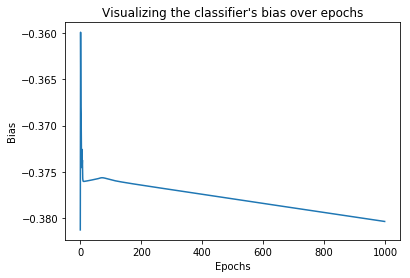

In [17]:
# Similarly, we will visualize the model's bias over epochs.

plt.plot(params['b'])
plt.xlabel('Epochs')
plt.ylabel('Bias')
plt.title('Visualizing the classifier\'s bias over epochs')
# plt.savefig(savedir + 'Q1_4.png', dpi=300, bbox_inches='tight')
plt.show()

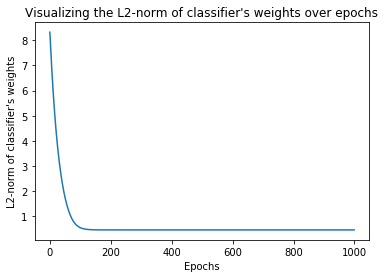

In [18]:
# Since it is tedious to visualize 64 weights and this does not scale 
# well, we then plot the L2-norm of the weights over epochs.

# Calculating the L2-norm for each epoch's weight vector.
params_W_L2_norm = np.array([norm(params['W'][idx], 2) for idx in range(train_epochs)])

plt.plot(params_W_L2_norm)
plt.xlabel('Epochs')
plt.ylabel('L2-norm of classifier\'s weights')
plt.title('Visualizing the L2-norm of classifier\'s weights over epochs')
# plt.savefig(savedir + 'Q1_5.png', dpi=300, bbox_inches='tight')
plt.show()

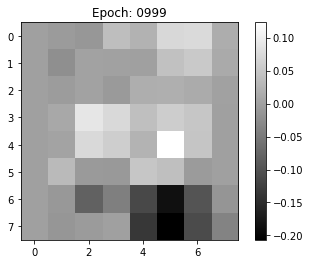

In [19]:
# Finally, we visualize the model weights as an animation composed of
# 8 x 8 images, each image corresponding to the weights from an epoch.

# We will save the weights as images first. Since there are 1000 epochs,
# we will save every 10th frame and the last frame.
for idx in np.append(np.arange(0, train_epochs, 10), (train_epochs - 1)):
    # Close any open plots.
    plt.close()
    # Reshape the weights to 8 x 8 and then show them in grayscale.
    plt.imshow(params['W'][idx].reshape(8, 8), cmap='gray')
    # Add a title to label the images.
    plt.title('Epoch: {:04d}'.format(idx))
    # Add a colorbar to explain the colors.
    plt.colorbar()
    # Save each image.
    plt.savefig(savedir + 'GIF_Frames_Q1/wts_{:04d}'.format(idx), dpi=150, bbox_inches='tight')
    
# Store the filenames of all the saved frames.
imgs = [savedir + 'GIF_Frames_Q1/' + f 
        for f in sorted(os.listdir(savedir + 'GIF_Frames_Q1/')) 
        if f.endswith('.png')]

# Initialize an empty list to store all the frames.
img_array = []

# Iterate over each image to store it in the list.
for f in imgs:
    # Open each image with OpenCV.
    img = cv2.imread(f)
    # Infer image height and width from shape.
    height, width, _ = img.shape
    # Define image size using height and width above.
    size = (width, height)
    # Append the image to the list.
    img_array.append(img)
    
# Initialize an OpenCV VideoWriter object to save the frames as a video.
# We set the frame rate of the video to 25 fps.
# Inspired by https://bit.ly/3vPyPuU
out = cv2.VideoWriter(savedir + 'Q1_6.avi', cv2.VideoWriter_fourcc(*'DIVX'), 25, size)

# Interate over each image in the list and write it as a frame of 
# the video.
for idx in range(len(img_array)):
    out.write(img_array[idx])

# Close the VideoWriter object.
out.release()

## Evaluating the trained classifier on the testing partition

In [20]:
# Calculate the classifier's performance by passing the ground truth
# and the predicted labels to the custom function.
accuracy, prec, rec, sens, spec, f1_score = calculate_metrics(y_true=y_test, y_pred=pred_test)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(prec))
print('Recall: {:.4f}'.format(rec))
print('Sensitivity: {:.4f}'.format(sens))
print('Specificity: {:.4f}'.format(spec))
print('F1-score: {:.4f}'.format(f1_score))

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
Sensitivity: 1.0000
Specificity: 1.0000
F1-score: 1.0000


## Analyzing the bias-variance tradeoff

We recall from the lecture that if the model exhibits a low training error but a large testing error (or equivalently, good performance on the training set and poor performance on the testing set), it exhibits a high variance and is said to have overfit to the training dataset.

On the other hand, if the model exhibits high training and test errors (or equivalently, poor performance on both training and test sets), it exhibits a high bias and is said to have underfit to the training dataset.

Now, let us look at one instance of both these scenarios and analyze the findings.

### A model with a high variance

In [21]:
# The set of hyperparameters that results in a classifier
# with a high variance.
params_highvar = {
    'n_epochs': 100,
    'lr': 1e-1,
    'reg_param': 0.,
    'batch_size': 10
}

# Train a classifier with these hyperparameters.
train_epochs = params_highvar['n_epochs']

clsfr = LogisticRegressionClassifier(n_features=n_feats, 
                                     lr=params_highvar['lr'], 
                                     reg_param=params_highvar['reg_param'], 
                                     batch_size=params_highvar['batch_size'], 
                                     n_epochs=1)

# Initialize empty dictionaries to keep track of epoch-wise loss
# values, classifier parameters, and classification accuracies.
losses, params, acc = {}, {}, {}

# Initialize the loss and accuracy dictionaries with zeros for 
# training and testing partitions.
losses['train'], losses['test'] = np.zeros(train_epochs), np.zeros(train_epochs)
acc['train'], acc['test'] = np.zeros(train_epochs), np.zeros(train_epochs)

# Initialize the parameter dictionary with zeros for the classifier's
# weights and biases.
params['W'], params['b'] = np.zeros((train_epochs, n_feats)), np.zeros(train_epochs)

# Fit the classifier one training epoch at a time, so as to keep track 
# of the metrics every epoch.
for epoch in range(train_epochs):
    # Fit the classifier for one epoch.
    clsfr.fit(x_train, y_train)
    # Log the training loss.
    losses['train'] = np.array(clsfr.loss_values_)
    # Log the weights and the bias of the classifier.
    params['W'][epoch], params['b'][epoch] = clsfr.params_['W'], clsfr.params_['b']
    
    # Calculate the model's predictions for the training and the test
    # partitions.
    pred_train = clsfr.predict(x_train, y_train, calculate_loss=False)
    pred_test, losses['test'][epoch] = clsfr.predict(x_test, y_test, calculate_loss=True)
    
    # Calculate the model's accuracy for the training and the test
    # partitions.
    acc['train'][epoch] = (pred_train == y_train).sum() / n_train
    acc['test'][epoch] = (pred_test == y_test).sum() / n_test

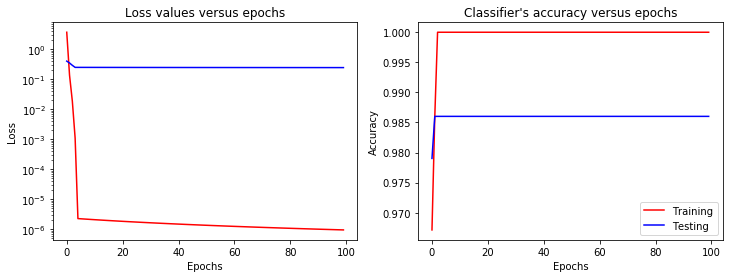

In [22]:
# Plot the loss values and the accuracies for training and
# testing splits to demonstrate the high variance.
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(losses['train'], 'r', label='Training')
axs[0].plot(losses['test'], 'b', label='Testing')
axs[0].set_yscale('log')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(acc['train'], 'r', label='Training')
axs[1].plot(acc['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
# plt.savefig(savedir + 'Q1_7.png', dpi=300, bbox_inches='tight')
plt.show()

**Analysis:** We see from the plots above that the loss values for the training set have become much smaller (~1e-6) as compared to the best model trained above, whereas the loss values for the testing set remain comparatively much larger.

Similarly, the model achieves 100% accuracy on the training set in less than 10 epochs, whereas the performance on the testing set is considerably lower and does not improve even as training continues.

Both these graphs indicate that the model has overfit to the training dataset and is an example of high variance.

### A model with a high bias

In [23]:
# The set of hyperparameters that results in a classifier
# with a high bias.
params_highbias = {
    'n_epochs': 100,
    'lr': 1e-3,
    'reg_param': 1.,
    'batch_size': 100
}

# Train a classifier with these hyperparameters.
train_epochs = params_highbias['n_epochs']

clsfr = LogisticRegressionClassifier(n_features=n_feats, 
                                     lr=params_highbias['lr'], 
                                     reg_param=params_highbias['reg_param'], 
                                     batch_size=params_highbias['batch_size'], 
                                     n_epochs=1)

# Initialize empty dictionaries to keep track of epoch-wise loss
# values, classifier parameters, and classification accuracies.
losses, params, acc = {}, {}, {}

# Initialize the loss and accuracy dictionaries with zeros for 
# training and testing partitions.
losses['train'], losses['test'] = np.zeros(train_epochs), np.zeros(train_epochs)
acc['train'], acc['test'] = np.zeros(train_epochs), np.zeros(train_epochs)

# Initialize the parameter dictionary with zeros for the classifier's
# weights and biases.
params['W'], params['b'] = np.zeros((train_epochs, n_feats)), np.zeros(train_epochs)

# Fit the classifier one training epoch at a time, so as to keep track 
# of the metrics every epoch.
for epoch in range(train_epochs):
    # Fit the classifier for one epoch.
    clsfr.fit(x_train, y_train)
    # Log the training loss.
    losses['train'] = np.array(clsfr.loss_values_)
    # Log the weights and the bias of the classifier.
    params['W'][epoch], params['b'][epoch] = clsfr.params_['W'], clsfr.params_['b']
    
    # Calculate the model's predictions for the training and the test
    # partitions.
    pred_train = clsfr.predict(x_train, y_train, calculate_loss=False)
    pred_test, losses['test'][epoch] = clsfr.predict(x_test, y_test, calculate_loss=True)
    
    # Calculate the model's accuracy for the training and the test
    # partitions.
    acc['train'][epoch] = (pred_train == y_train).sum() / n_train
    acc['test'][epoch] = (pred_test == y_test).sum() / n_test

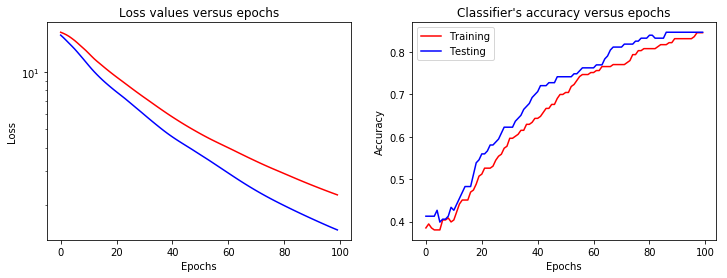

In [24]:
# Plot the loss values and the accuracies for training and
# testing splits to demonstrate the high variance.
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(losses['train'], 'r', label='Training')
axs[0].plot(losses['test'], 'b', label='Testing')
axs[0].set_yscale('log')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(acc['train'], 'r', label='Training')
axs[1].plot(acc['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
# plt.savefig(savedir + 'Q1_8.png', dpi=300, bbox_inches='tight')
plt.show()

**Analysis:** We see from the plots above that the loss values for both the training set and the testing set remain quite large even towards the end of training.

Similarly, the model's accuracy on both training and testing sets never approaches high values and flattens around 80%.

Both these graphs indicate that the model has underfit to the training dataset and is an example of high bias.

### Another model with a high bias

In [25]:
# The set of hyperparameters that results in a classifier
# with a high bias.
params_highbias = {
    'n_epochs': 100,
    'lr': 1e-4,
    'reg_param': 1.,
    'batch_size': 100
}

# Train a classifier with these hyperparameters.
train_epochs = params_highbias['n_epochs']

clsfr = LogisticRegressionClassifier(n_features=n_feats, 
                                     lr=params_highbias['lr'], 
                                     reg_param=params_highbias['reg_param'], 
                                     batch_size=params_highbias['batch_size'], 
                                     n_epochs=1)

# Initialize empty dictionaries to keep track of epoch-wise loss
# values, classifier parameters, and classification accuracies.
losses, params, acc = {}, {}, {}

# Initialize the loss and accuracy dictionaries with zeros for 
# training and testing partitions.
losses['train'], losses['test'] = np.zeros(train_epochs), np.zeros(train_epochs)
acc['train'], acc['test'] = np.zeros(train_epochs), np.zeros(train_epochs)

# Initialize the parameter dictionary with zeros for the classifier's
# weights and biases.
params['W'], params['b'] = np.zeros((train_epochs, n_feats)), np.zeros(train_epochs)

# Fit the classifier one training epoch at a time, so as to keep track 
# of the metrics every epoch.
for epoch in range(train_epochs):
    # Fit the classifier for one epoch.
    clsfr.fit(x_train, y_train)
    # Log the training loss.
    losses['train'] = np.array(clsfr.loss_values_)
    # Log the weights and the bias of the classifier.
    params['W'][epoch], params['b'][epoch] = clsfr.params_['W'], clsfr.params_['b']
    
    # Calculate the model's predictions for the training and the test
    # partitions.
    pred_train = clsfr.predict(x_train, y_train, calculate_loss=False)
    pred_test, losses['test'][epoch] = clsfr.predict(x_test, y_test, calculate_loss=True)
    
    # Calculate the model's accuracy for the training and the test
    # partitions.
    acc['train'][epoch] = (pred_train == y_train).sum() / n_train
    acc['test'][epoch] = (pred_test == y_test).sum() / n_test

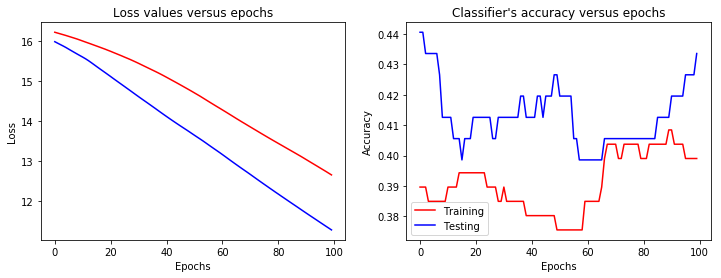

In [26]:
# Plot the loss values and the accuracies for training and
# testing splits to demonstrate the high variance.
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(losses['train'], 'r', label='Training')
axs[0].plot(losses['test'], 'b', label='Testing')
# axs[0].set_yscale('log')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(acc['train'], 'r', label='Training')
axs[1].plot(acc['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
# plt.savefig(savedir + 'Q1_9.png', dpi=300, bbox_inches='tight')
plt.show()

**Analysis: This is an example of extreme underfitting.** We see from the plots above that the loss values for both the training set and the testing set are very large (> 10) even towards the end of training.

Similarly, the model's accuracy on both training and testing sets is very poor and is less than 50% (meaning it is worse than random guessing for a binary classification task).

Both these graphs indicate that the model has extremely underfit to the training dataset and is an example of very high bias.

# Question 2

## Loading, validating, and exploring the dataset

In [27]:
mnist_data = fetch_openml('mnist_784', version=1, return_X_y=False)

print("Shape of input data:", mnist_data.data.shape)
print("Shape of target labels:", mnist_data.target.shape)

Shape of input data: (70000, 784)
Shape of target labels: (70000,)


In [28]:
# We want to count the sample population of each target label in the dataset.

print("Class-wise sample counts")

# For every label, count the number of occurrences of it in the dataset.
for label in range(10):
    # Since the labels in this dataset are strings, we convert them to 
    # integers first.
    print(label, '->' , len(np.where(mnist_data.target.astype(np.int_) == label)[0]))

Class-wise sample counts
0 -> 6903
1 -> 7877
2 -> 6990
3 -> 7141
4 -> 6824
5 -> 6313
6 -> 6876
7 -> 7293
8 -> 6825
9 -> 6958


## Select the 2 classes based on user inputs  `class0` and `class1`

In [29]:
class0, class1 = 2, 7

## Partition the dataset into training and testing splits

In [30]:
# Specify the percentage of the dataset to be held out for testing
test_frac = 0.4

In [31]:
# Use a custom-designed function that takes the dataset, the 2 classes, 
# the test fraction, and the random seed value as input, and returns
# training and testing inputs and labels.
x_train, x_test, y_train, y_test = prepare_data(X=mnist_data.data, 
                                                Y=mnist_data.target.astype(np.int_), 
                                                class0=class0, 
                                                class1=class1, 
                                                test_split_fraction=test_frac, 
                                                seedval=seedval)

print('Training partition input data shape:', x_train.shape)
print('Training partition labels shape:', y_train.shape)
print('Testing partition input data shape:', x_test.shape)
print('Testing partition labels shape:', y_test.shape)

# Infer the number of data points in training and testing partitions
# and the number of features from the shape
n_train, n_test, n_feats = x_train.shape[0], x_test.shape[0], x_train.shape[1]

Training partition input data shape: (8569, 784)
Training partition labels shape: (8569,)
Testing partition input data shape: (5714, 784)
Testing partition labels shape: (5714,)


## Training the classifier

### No regularization of model weights

In [32]:
# The set of hyperparameters that results in a classifier
# trained with no regularization of model weights.
params_noreg = {
    'n_epochs': 500,
    'lr': 1e-3,
    'reg_param': 0.,
    'batch_size': 1000
}

# Initialize a classifier with the hyperparameters set to the values above.

train_epochs = params_noreg['n_epochs']

clsfr = LogisticRegressionClassifier(n_features=n_feats, 
                                     lr=params_noreg['lr'], 
                                     reg_param=params_noreg['reg_param'], 
                                     batch_size=params_noreg['batch_size'], 
                                     n_epochs=1)

# Initialize empty dictionaries to keep track of epoch-wise loss
# values, classifier parameters, and classification accuracies.
losses, params, acc = {}, {}, {}

# Initialize the loss and accuracy dictionaries with zeros for 
# training and testing partitions.
losses['train'], losses['test'] = np.zeros(train_epochs), np.zeros(train_epochs)
acc['train'], acc['test'] = np.zeros(train_epochs), np.zeros(train_epochs)

# Initialize the parameter dictionary with zeros for the classifier's
# weights and biases.
params['W'], params['b'] = np.zeros((train_epochs, n_feats)), np.zeros(train_epochs)

# Fit the classifier one training epoch at a time, so as to keep track 
# of the metrics every epoch.
for epoch in range(train_epochs):
    # Fit the classifier for one epoch.
    clsfr.fit(x_train, y_train)
    # Log the training loss.
    losses['train'] = np.array(clsfr.loss_values_)
    # Log the weights and the bias of the classifier.
    params['W'][epoch], params['b'][epoch] = clsfr.params_['W'], clsfr.params_['b']
    
    # Calculate the model's predictions for the training and the test
    # partitions.
    pred_train = clsfr.predict(x_train, y_train, calculate_loss=False)
    pred_test, losses['test'][epoch] = clsfr.predict(x_test, y_test, calculate_loss=True)
    
    # Calculate the model's accuracy for the training and the test
    # partitions.
    acc['train'][epoch] = (pred_train == y_train).sum() / n_train
    acc['test'][epoch] = (pred_test == y_test).sum() / n_test

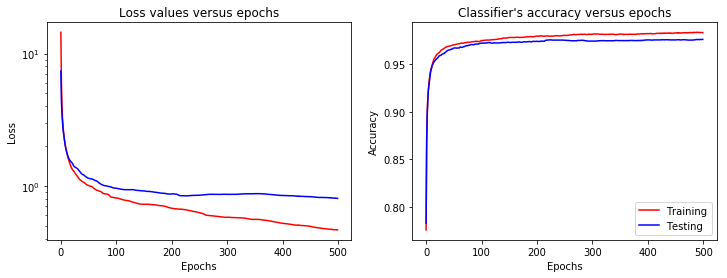

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(losses['train'], 'r', label='Training')
axs[0].plot(losses['test'], 'b', label='Testing')
axs[0].set_yscale('log')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(acc['train'], 'r', label='Training')
axs[1].plot(acc['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
# plt.savefig(savedir + 'Q2_1.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
# Calculate the classifier's performance by passing the ground truth
# and the predicted labels to the custom function.
accuracy, prec, rec, sens, spec, f1_score = calculate_metrics(y_true=y_test, y_pred=pred_test)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(prec))
print('Recall: {:.4f}'.format(rec))
print('Sensitivity: {:.4f}'.format(sens))
print('Specificity: {:.4f}'.format(spec))
print('F1-score: {:.4f}'.format(f1_score))

Accuracy: 0.9757
Precision: 0.9770
Recall: 0.9753
Sensitivity: 0.9753
Specificity: 0.9760
F1-score: 0.9762


### Medium/appropriate amount of regularization of model weights

In [35]:
# The set of hyperparameters that results in a classifier
# trained with an appropriate amount of regularization of
# model weights.
params_somereg = {
    'n_epochs': 1000,
    'lr': 1e-3,
    'reg_param': 0.1,
    'batch_size': 1000
}

# Initialize a classifier with the hyperparameters set to the values above.

train_epochs = params_somereg['n_epochs']

clsfr = LogisticRegressionClassifier(n_features=n_feats, 
                                     lr=params_somereg['lr'], 
                                     reg_param=params_somereg['reg_param'], 
                                     batch_size=params_somereg['batch_size'], 
                                     n_epochs=1)

# Initialize empty dictionaries to keep track of epoch-wise loss
# values, classifier parameters, and classification accuracies.
losses, params, acc = {}, {}, {}

# Initialize the loss and accuracy dictionaries with zeros for 
# training and testing partitions.
losses['train'], losses['test'] = np.zeros(train_epochs), np.zeros(train_epochs)
acc['train'], acc['test'] = np.zeros(train_epochs), np.zeros(train_epochs)

# Initialize the parameter dictionary with zeros for the classifier's
# weights and biases.
params['W'], params['b'] = np.zeros((train_epochs, n_feats)), np.zeros(train_epochs)

# Fit the classifier one training epoch at a time, so as to keep track 
# of the metrics every epoch.
for epoch in range(train_epochs):
    # Fit the classifier for one epoch.
    clsfr.fit(x_train, y_train)
    # Log the training loss.
    losses['train'] = np.array(clsfr.loss_values_)
    # Log the weights and the bias of the classifier.
    params['W'][epoch], params['b'][epoch] = clsfr.params_['W'], clsfr.params_['b']
    
    # Calculate the model's predictions for the training and the test
    # partitions.
    pred_train = clsfr.predict(x_train, y_train, calculate_loss=False)
    pred_test, losses['test'][epoch] = clsfr.predict(x_test, y_test, calculate_loss=True)
    
    # Calculate the model's accuracy for the training and the test
    # partitions.
    acc['train'][epoch] = (pred_train == y_train).sum() / n_train
    acc['test'][epoch] = (pred_test == y_test).sum() / n_test

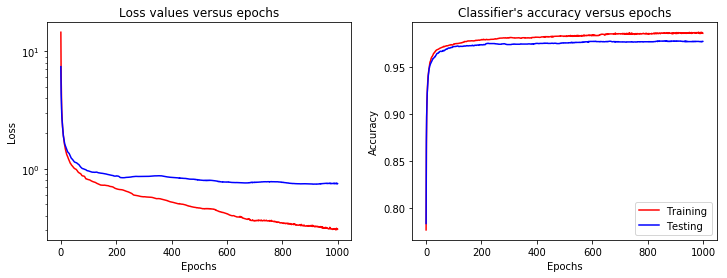

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(losses['train'], 'r', label='Training')
axs[0].plot(losses['test'], 'b', label='Testing')
axs[0].set_yscale('log')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(acc['train'], 'r', label='Training')
axs[1].plot(acc['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
# plt.savefig(savedir + 'Q2_2.png', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
# Calculate the classifier's performance by passing the ground truth
# and the predicted labels to the custom function.
accuracy, prec, rec, sens, spec, f1_score = calculate_metrics(y_true=y_test, y_pred=pred_test)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(prec))
print('Recall: {:.4f}'.format(rec))
print('Sensitivity: {:.4f}'.format(sens))
print('Specificity: {:.4f}'.format(spec))
print('F1-score: {:.4f}'.format(f1_score))

Accuracy: 0.9772
Precision: 0.9774
Recall: 0.9781
Sensitivity: 0.9781
Specificity: 0.9764
F1-score: 0.9777


### High regularization of model weights

In [38]:
# The set of hyperparameters that results in a classifier
# trained with a high regularization of model weights.
params_highreg = {
    'n_epochs': 1000,
    'lr': 1e-3,
    'reg_param': 10,
    'batch_size': 1000
}

# Initialize a classifier with the hyperparameters set to the values above.

train_epochs = params_highreg['n_epochs']

clsfr = LogisticRegressionClassifier(n_features=n_feats, 
                                     lr=params_highreg['lr'], 
                                     reg_param=params_highreg['reg_param'], 
                                     batch_size=params_highreg['batch_size'], 
                                     n_epochs=1)

# Initialize empty dictionaries to keep track of epoch-wise loss
# values, classifier parameters, and classification accuracies.
losses, params, acc = {}, {}, {}

# Initialize the loss and accuracy dictionaries with zeros for 
# training and testing partitions.
losses['train'], losses['test'] = np.zeros(train_epochs), np.zeros(train_epochs)
acc['train'], acc['test'] = np.zeros(train_epochs), np.zeros(train_epochs)

# Initialize the parameter dictionary with zeros for the classifier's
# weights and biases.
params['W'], params['b'] = np.zeros((train_epochs, n_feats)), np.zeros(train_epochs)

# Fit the classifier one training epoch at a time, so as to keep track 
# of the metrics every epoch.
for epoch in range(train_epochs):
    # Fit the classifier for one epoch.
    clsfr.fit(x_train, y_train)
    # Log the training loss.
    losses['train'] = np.array(clsfr.loss_values_)
    # Log the weights and the bias of the classifier.
    params['W'][epoch], params['b'][epoch] = clsfr.params_['W'], clsfr.params_['b']
    
    # Calculate the model's predictions for the training and the test
    # partitions.
    pred_train = clsfr.predict(x_train, y_train, calculate_loss=False)
    pred_test, losses['test'][epoch] = clsfr.predict(x_test, y_test, calculate_loss=True)
    
    # Calculate the model's accuracy for the training and the test
    # partitions.
    acc['train'][epoch] = (pred_train == y_train).sum() / n_train
    acc['test'][epoch] = (pred_test == y_test).sum() / n_test

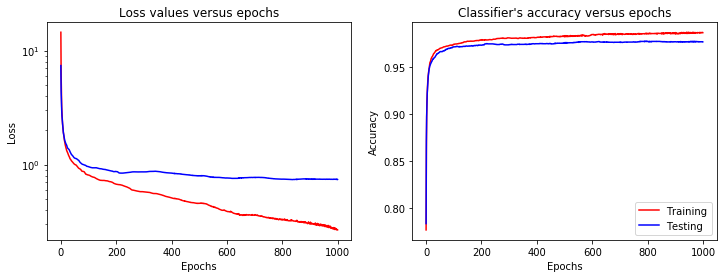

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(losses['train'], 'r', label='Training')
axs[0].plot(losses['test'], 'b', label='Testing')
axs[0].set_yscale('log')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(acc['train'], 'r', label='Training')
axs[1].plot(acc['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
# plt.savefig(savedir + 'Q2_3.png', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
# Calculate the classifier's performance by passing the ground truth
# and the predicted labels to the custom function.
accuracy, prec, rec, sens, spec, f1_score = calculate_metrics(y_true=y_test, y_pred=pred_test)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(prec))
print('Recall: {:.4f}'.format(rec))
print('Sensitivity: {:.4f}'.format(sens))
print('Specificity: {:.4f}'.format(spec))
print('F1-score: {:.4f}'.format(f1_score))

Accuracy: 0.9771
Precision: 0.9780
Recall: 0.9770
Sensitivity: 0.9770
Specificity: 0.9771
F1-score: 0.9775


## Analyzing the bias-variance tradeoff

### A model with a high variance

In [41]:
# The set of hyperparameters that results in a classifier
# with a high variance.
params_highvar = {
    'n_epochs': 1000,
    'lr': 1e-1,
    'reg_param': 0.,
    'batch_size': 1000
}

# Train a classifier with these hyperparameters.
train_epochs = params_highvar['n_epochs']

clsfr = LogisticRegressionClassifier(n_features=n_feats, 
                                     lr=params_highvar['lr'], 
                                     reg_param=params_highvar['reg_param'], 
                                     batch_size=params_highvar['batch_size'], 
                                     n_epochs=1)

# Initialize empty dictionaries to keep track of epoch-wise loss
# values, classifier parameters, and classification accuracies.
losses, params, acc = {}, {}, {}

# Initialize the loss and accuracy dictionaries with zeros for 
# training and testing partitions.
losses['train'], losses['test'] = np.zeros(train_epochs), np.zeros(train_epochs)
acc['train'], acc['test'] = np.zeros(train_epochs), np.zeros(train_epochs)

# Initialize the parameter dictionary with zeros for the classifier's
# weights and biases.
params['W'], params['b'] = np.zeros((train_epochs, n_feats)), np.zeros(train_epochs)

# Fit the classifier one training epoch at a time, so as to keep track 
# of the metrics every epoch.
for epoch in range(train_epochs):
    # Fit the classifier for one epoch.
    clsfr.fit(x_train, y_train)
    # Log the training loss.
    losses['train'] = np.array(clsfr.loss_values_)
    # Log the weights and the bias of the classifier.
    params['W'][epoch], params['b'][epoch] = clsfr.params_['W'], clsfr.params_['b']
    
    # Calculate the model's predictions for the training and the test
    # partitions.
    pred_train = clsfr.predict(x_train, y_train, calculate_loss=False)
    pred_test, losses['test'][epoch] = clsfr.predict(x_test, y_test, calculate_loss=True)
    
    # Calculate the model's accuracy for the training and the test
    # partitions.
    acc['train'][epoch] = (pred_train == y_train).sum() / n_train
    acc['test'][epoch] = (pred_test == y_test).sum() / n_test

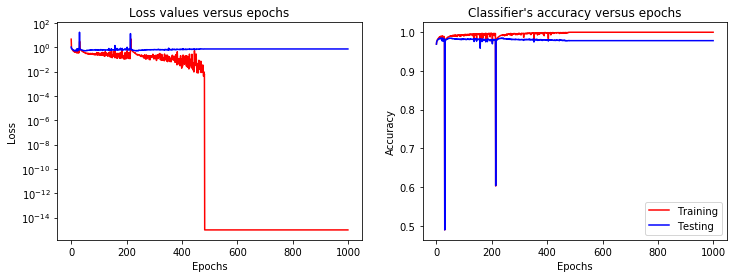

In [42]:
# Plot the loss values and the accuracies for training and
# testing splits to demonstrate the high variance.
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(losses['train'], 'r', label='Training')
axs[0].plot(losses['test'], 'b', label='Testing')
axs[0].set_yscale('log')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(acc['train'], 'r', label='Training')
axs[1].plot(acc['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
# plt.savefig(savedir + 'Q2_4.png', dpi=300, bbox_inches='tight')
plt.show()

**Analysis:** We see from the plots above that the loss values for the training set have become very small (< 1e-14) as compared to the best model trained above, whereas the loss values for the testing set remain comparatively much larger (~1e0).

Similarly, the model achieves 100% accuracy on the training set in ~200 epochs, whereas the performance on the testing set is comparatively lower and does not improve even as training continues. Instead, we see that the testing accuracy decreases after ~500 epochs.

Both these graphs indicate that the model has overfit to the training dataset and is an example of high variance.

### A model with a high bias

In [43]:
# The set of hyperparameters that results in a classifier
# with a high bias.
params_highbias = {
    'n_epochs': 100,
    'lr': 1e-5,
    'reg_param': 1.,
    'batch_size': 1000
}

# Train a classifier with these hyperparameters.
train_epochs = params_highbias['n_epochs']

clsfr = LogisticRegressionClassifier(n_features=n_feats, 
                                     lr=params_highbias['lr'], 
                                     reg_param=params_highbias['reg_param'], 
                                     batch_size=params_highbias['batch_size'], 
                                     n_epochs=1)

# Initialize empty dictionaries to keep track of epoch-wise loss
# values, classifier parameters, and classification accuracies.
losses, params, acc = {}, {}, {}

# Initialize the loss and accuracy dictionaries with zeros for 
# training and testing partitions.
losses['train'], losses['test'] = np.zeros(train_epochs), np.zeros(train_epochs)
acc['train'], acc['test'] = np.zeros(train_epochs), np.zeros(train_epochs)

# Initialize the parameter dictionary with zeros for the classifier's
# weights and biases.
params['W'], params['b'] = np.zeros((train_epochs, n_feats)), np.zeros(train_epochs)

# Fit the classifier one training epoch at a time, so as to keep track 
# of the metrics every epoch.
for epoch in range(train_epochs):
    # Fit the classifier for one epoch.
    clsfr.fit(x_train, y_train)
    # Log the training loss.
    losses['train'] = np.array(clsfr.loss_values_)
    # Log the weights and the bias of the classifier.
    params['W'][epoch], params['b'][epoch] = clsfr.params_['W'], clsfr.params_['b']
    
    # Calculate the model's predictions for the training and the test
    # partitions.
    pred_train = clsfr.predict(x_train, y_train, calculate_loss=False)
    pred_test, losses['test'][epoch] = clsfr.predict(x_test, y_test, calculate_loss=True)
    
    # Calculate the model's accuracy for the training and the test
    # partitions.
    acc['train'][epoch] = (pred_train == y_train).sum() / n_train
    acc['test'][epoch] = (pred_test == y_test).sum() / n_test

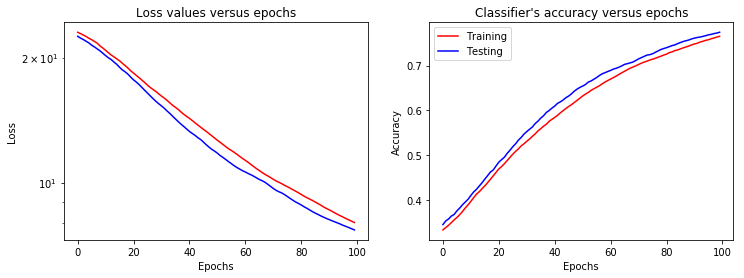

In [44]:
# Plot the loss values and the accuracies for training and
# testing splits to demonstrate the high variance.
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axs[0].plot(losses['train'], 'r', label='Training')
axs[0].plot(losses['test'], 'b', label='Testing')
axs[0].set_yscale('log')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Loss values versus epochs')

axs[1].plot(acc['train'], 'r', label='Training')
axs[1].plot(acc['test'], 'b', label='Testing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].title.set_text('Classifier\'s accuracy versus epochs')

plt.legend()
# plt.savefig(savedir + 'Q2_5.png', dpi=300, bbox_inches='tight')
plt.show()

**Analysis:** We see from the plots above that the loss values for both the training set and the testing set remain quite large (~1e1) even towards the end of training.

Similarly, the model's accuracy on both training and testing sets never approaches high values and only remains around 70%-80%.

Both these graphs indicate that the model has underfit to the training dataset and is an example of high bias.